In [1]:
med <- read.csv('MedicalData.csv')

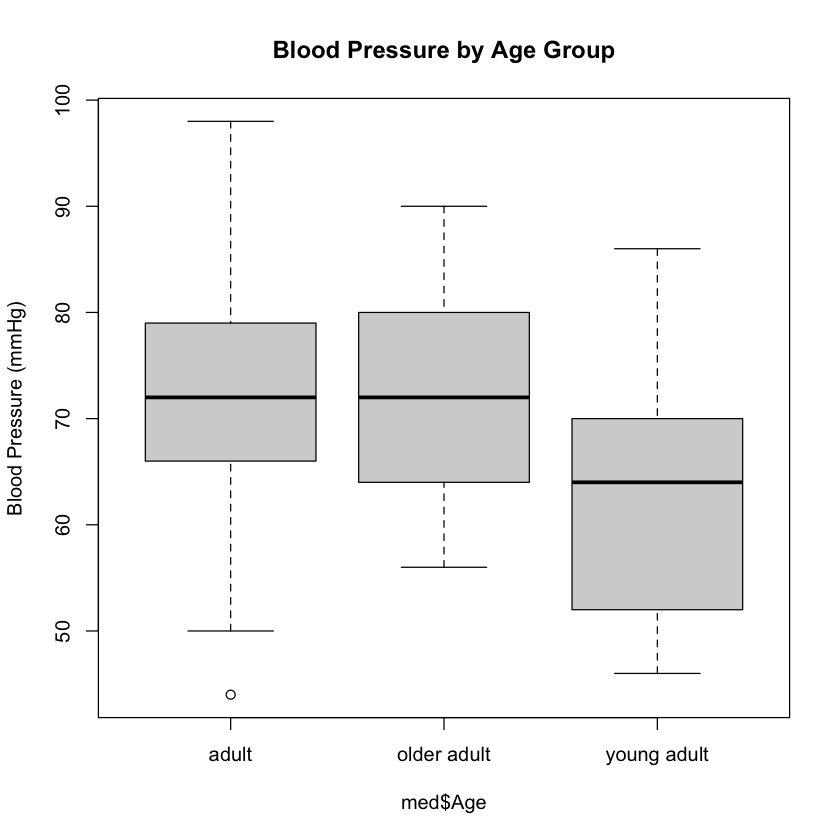

In [2]:
boxplot(med$BP~med$Age,main='Blood Pressure by Age Group',ylab='Blood Pressure (mmHg)')

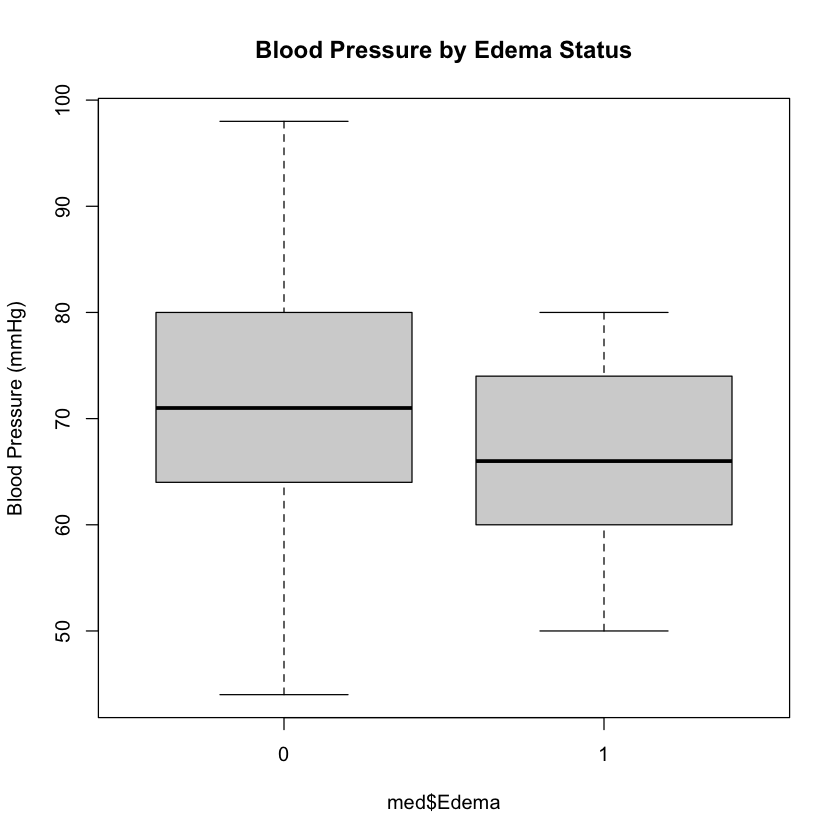

In [3]:
boxplot(med$BP~med$Edema,main='Blood Pressure by Edema Status',ylab='Blood Pressure (mmHg)')

In [4]:
med$Edema <- as.factor(med$Edema)

In [5]:
library(car)

Loading required package: carData



In [6]:
leveneTest(med$BP~med$Age)

Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.06434128,0.9377105
,152,NA,NA


In [7]:
leveneTest(med$BP~med$Edema)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,0.4639229,0.4968258
,153,NA,NA


In [8]:
my2aov <- aov(BP~Age*Edema, data=med, contrasts=list(Age=contr.sum, Edema=contr.sum))

In [9]:
Anova(my2aov, type=3)

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),106466.1787,1,889.5496184,1.062461e-64
Age,647.7921,2,2.7062265,7.007192e-02
Edema,364.8852,1,3.0487001,8.286284e-02
Age:Edema,162.2852,2,0.6779654,5.092077e-01
Residuals,17833.1375,149,NA,NA


In [10]:
summary.lm(my2aov)$adj.r.squared

[1] 0.06981484

In [11]:
TukeyHSD(my2aov)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = BP ~ Age * Edema, data = med, contrasts = list(Age = contr.sum, Edema = contr.sum))

$Age
                              diff        lwr        upr     p adj
older adult-adult       -0.3602694  -5.983326  5.2627868 0.9873979
young adult-adult       -8.1469871 -13.615573 -2.6784015 0.0016127
young adult-older adult -7.7867178 -14.712993 -0.8604423 0.0233403

$Edema
        diff      lwr      upr     p adj
1-0 -5.13693 -11.8993 1.625439 0.1354592

$`Age:Edema`
                                   diff        lwr       upr     p adj
older adult:0-adult:0        -0.4245648  -7.905319  7.056189 0.9999833
young adult:0-adult:0        -7.9635258 -14.763835 -1.163217 0.0116683
adult:1-adult:0              -6.7063830 -21.202788  7.790023 0.7647082
older adult:1-adult:0        -1.9063830 -16.402788 12.590023 0.9989567
young adult:1-adult:0       -23.1063830 -54.859732  8.646966 0.2924886
young adult:0-old